In [1219]:

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import cv2
from pathlib import Path
from scipy.interpolate import interp1d
import carla
from scipy.spatial.transform import Rotation as R
import pymap3d as pm

In [1220]:
carla_path = Path("./output/pure_carla/carla2k19/Chunk_1/batch1/1")
comma_path = Path("../../datasets/comma2k19/Chunk_1/b0c9d2329ad1606b|2018-07-27--06-50-48/14")


# Comparing processing of positions and orientations

Functions to convert between carla positions and orientations and the comma2k way.

In [1221]:
# HERE: The one currently in use
# TODO: Why is stuff so small?? (Ulrik)
def euler_to_quaternion2(map: carla.Map, location: carla.Location, rotation: carla.Rotation):
    origin_geolocation = map.transform_to_geolocation(carla.Location(0, 0, 0)) 
    # print("origin_geolocation = ", origin_geolocation.latitude, origin_geolocation.longitude, origin_geolocation.altitude)
    lat0 = np.radians(origin_geolocation.latitude)
    lon0 = np.radians(origin_geolocation.longitude)
    # alt0 = origin_geolocation.altitude

    # I know this rot matrix works in the original implementation
    # Construct rotation matrix from ECEF to ENU frames
    # https://gssc.esa.int/navipedia/index.php/Transformations_between_ECEF_and_ENU_coordinates
    # r = R.from_matrix([
    #     [-np.sin(lon0),  -np.cos(lon0)*np.sin(lat0),   np.cos(lon0)*np.cos(lat0)],
    #     [np.cos(lon0),   -np.sin(lon0)*np.sin(lat0),   np.sin(lon0)*np.cos(lat0)],
    #     [0,               np.cos(lat0),                np.sin(lat0)             ]]).inv()

    # I think we should remove .inv() because I think original example was from ECEF to ENU
    r = R.from_matrix(
        [
            [-np.sin(lon0), -np.cos(lon0) * np.sin(lat0), np.cos(lon0) * np.cos(lat0)],
            [np.cos(lon0), -np.sin(lon0) * np.sin(lat0), np.sin(lon0) * np.cos(lat0)],
            [0, np.cos(lat0), np.sin(lat0)],
        ]
    )
    # https://carla.readthedocs.io/en/latest/python_api/#carlarotation
    # https://se.mathworks.com/help/uav/ug/coordinate-systems-for-unreal-engine-simulation-in-uav-toolbox.html
    # In carla
    # pitch is right-handed rotation around the y-axis
    # yaw is rotation around the z-axis
    # roll is rotation around the x-axis
    # To adjust for the difference in coordinate systems, we need to negate pitch and yaw
    x = np.radians(rotation.roll)
    # NOTE: Changing x to negative does nothing
    y = -np.radians(rotation.pitch)
    z = -np.radians(rotation.yaw)


    enu_rot = R.from_euler("xyz", (x, y, z), degrees=False)
    ecef_rot = r.as_matrix() @ enu_rot.as_matrix()
    # This returns the quaternion on the [x, y, z, w] format
    ecef_orientation = R.from_matrix(ecef_rot).as_quat()
    x = ecef_orientation[0]
    y = ecef_orientation[1]
    z = ecef_orientation[2]
    w = ecef_orientation[3]

    # print(f"{ecef_orientation = }")
    return np.array([w, x, y, z])

# HERE: The one currently in use
def carla_location_to_ecef(map: carla.Map, location: carla.Location):
    # I want to check if this finds the origin
    origin_geolocation = map.transform_to_geolocation(carla.Location(0, 0, 0)) 
    # geolocation = map.transform_to_geolocation(location)
    # https://docs.unrealengine.com/4.27/en-US/BuildingWorlds/Georeferencing/
    e_enu = location.x
    n_enu = -location.y  # Negate y to convert from right-handed to left-handed coordinate system
    u_enu = location.z

    x, y, z = pm.enu2ecef(
        e_enu,
        n_enu, 
        u_enu,
        np.radians(origin_geolocation.latitude),
        np.radians(origin_geolocation.longitude),
        origin_geolocation.altitude,
        deg=False,
    )
    # latitude = geolocation.latitude
    # longitude = geolocation.longitude
    # altitude = geolocation.altitude

    return np.array([x, y, z])

Functions used to process positions and orientations in the comma2k dataset to plot the trajectory of the vehicle.

In [1222]:
def quat2rot(quats):
  quats = np.array(quats)
  input_shape = quats.shape
  quats = np.atleast_2d(quats)
  Rs = np.zeros((quats.shape[0], 3, 3))
  q0 = quats[:, 0]
  q1 = quats[:, 1]
  q2 = quats[:, 2]
  q3 = quats[:, 3]
  Rs[:, 0, 0] = q0 * q0 + q1 * q1 - q2 * q2 - q3 * q3
  Rs[:, 0, 1] = 2 * (q1 * q2 - q0 * q3)
  Rs[:, 0, 2] = 2 * (q0 * q2 + q1 * q3)
  Rs[:, 1, 0] = 2 * (q1 * q2 + q0 * q3)
  Rs[:, 1, 1] = q0 * q0 - q1 * q1 + q2 * q2 - q3 * q3
  Rs[:, 1, 2] = 2 * (q2 * q3 - q0 * q1)
  Rs[:, 2, 0] = 2 * (q1 * q3 - q0 * q2)
  Rs[:, 2, 1] = 2 * (q0 * q1 + q2 * q3)
  Rs[:, 2, 2] = q0 * q0 - q1 * q1 - q2 * q2 + q3 * q3

  if len(input_shape) < 2:
    return Rs[0]
  else:
    return Rs


def process_pose(frame_positions_in, frame_orientations_in, seq_length):
    num_pts = 10 * 20  # 10 s * 20 Hz = 200 frames DONT CHANGE
    fix_seq_length = seq_length - num_pts - 1  # Is 800 when not in demo
    seq_start_idx = seq_length - (fix_seq_length + num_pts)
    seq_start_idx = np.random.randint(1, seq_start_idx + 1)
    seq_end_idx = seq_start_idx + fix_seq_length
    frame_positions = frame_positions_in[seq_start_idx : seq_end_idx + num_pts]
    frame_orientations = frame_orientations_in[seq_start_idx : seq_end_idx + num_pts]
    t_anchors = np.array(
            (
                0.0,
                0.00976562,
                0.0390625,
                0.08789062,
                0.15625,
                0.24414062,
                0.3515625,
                0.47851562,
                0.625,
                0.79101562,
                0.9765625,
                1.18164062,
                1.40625,
                1.65039062,
                1.9140625,
                2.19726562,
                2.5,
                2.82226562,
                3.1640625,
                3.52539062,
                3.90625,
                4.30664062,
                4.7265625,
                5.16601562,
                5.625,
                6.10351562,
                6.6015625,
                7.11914062,
                7.65625,
                8.21289062,
                8.7890625,
                9.38476562,
                10.0,
            )
        )
    t_idx = np.linspace(0, 10, num=num_pts)

    future_poses = []
    for i in range(fix_seq_length):
        # It is using the current rotation as reference
        ecef_from_local = quat2rot(frame_orientations[i])
        local_from_ecef = ecef_from_local.T
        print(f"{local_from_ecef = }")
        frame_positions_local = np.einsum(
            "ij,kj->ki", local_from_ecef, frame_positions - frame_positions[i]  # remove local_from_ecef[i]
        ).astype(np.float32)

        # Time-Anchor like OpenPilot
        fs = [
            interp1d(t_idx, frame_positions_local[i : i + num_pts, j])
            for j in range(3)
        ]
        interp_positions = [fs[j](t_anchors)[:, None] for j in range(3)]
        interp_positions = np.concatenate(interp_positions, axis=1)

        future_poses.append(interp_positions)
    future_poses = torch.tensor(np.array(future_poses), dtype=torch.float32)
    return future_poses

In [1223]:
seq_length = 1200

In [1224]:
def plot_trajectory(poses, index=0):
    poses = poses[index]
    plot_args = dict(label="gt", alpha=1, linewidth=2)
    plt.plot(poses[:, 1], poses[:, 0], "o-", **plot_args)
    plt.xlim((-30, 30))
    plt.ylim((-100, 200))
    plt.show()

In [1225]:
def load_video_images(path: str):
    frames = []
    video = cv2.VideoCapture(path)
    while video.isOpened():
        ret, frame = video.read()
        if not ret:
            break
        frames.append(frame)
    return frames



# CARLA

In [1226]:
# These are original carla positions and orientations in their own coordinate system
carla_positions_np = np.load(carla_path / "global_pose/frame_positions")
carla_orientations_np = np.load(carla_path / "global_pose/frame_orientations")
carla_positions = [carla.Location(pos[0], pos[1], pos[2]) for pos in carla_positions_np]
carla_orientations = [carla.Rotation(pos[0], pos[1], pos[2]) for pos in carla_orientations_np]

def load_carla_map():
    with open("/home/ulrikro/code/Carla2/CARLA_0.9.15/CarlaUE4/Content/Carla/Maps/OpenDrive/Town01.xodr", "r") as file:
        data = file.read()
        return carla.Map("Town01", data)

carla_map = load_carla_map()
carla_ecef_pos = np.array([carla_location_to_ecef(carla_map, pos) for pos in carla_positions])
carla_ecef_rot = np.array([euler_to_quaternion2(carla_map, pos, rot) for pos, rot in zip(carla_positions, carla_orientations)])
print("carla_ecef_pos.shape", carla_ecef_pos.shape)
print("carla_ecef_rot.shape", carla_ecef_rot.shape)

carla_ecef_pos.shape (1200, 3)
carla_ecef_rot.shape (1200, 4)


In [1227]:
np.set_printoptions(suppress=True, precision=5)
carla_ecef_rot[0:5]

array([[ 0.01344, -0.01223,  0.70692,  0.70706],
       [ 0.00077, -0.00079,  0.70729,  0.70692],
       [ 0.00155, -0.00158,  0.70747,  0.70674],
       [ 0.00232, -0.00237,  0.70765,  0.70655],
       [ 0.00309, -0.00316,  0.70784,  0.70636]])

In [1228]:
# Process carla poses
carla_future_poses = process_pose(carla_ecef_pos, carla_ecef_rot, seq_length)
carla_future_poses.size()

local_from_ecef = array([[-1.     , -0.00003, -0.00221],
       [-0.00221,  0.00052,  1.     ],
       [-0.00002,  1.     , -0.00052]])
local_from_ecef = array([[-0.99999, -0.00005, -0.00443],
       [-0.00443,  0.00104,  0.99999],
       [-0.00005,  1.     , -0.00104]])
local_from_ecef = array([[-0.99998, -0.00008, -0.00664],
       [-0.00664,  0.00156,  0.99998],
       [-0.00007,  1.     , -0.00156]])
local_from_ecef = array([[-0.99996, -0.00011, -0.00885],
       [-0.00885,  0.00208,  0.99996],
       [-0.00009,  1.     , -0.00208]])
local_from_ecef = array([[-0.99995,  0.00028, -0.0097 ],
       [-0.0097 ,  0.0007 ,  0.99995],
       [ 0.00029,  1.     , -0.00069]])
local_from_ecef = array([[-0.99995,  0.00081, -0.00952],
       [-0.00952,  0.00033,  0.99995],
       [ 0.00081,  1.     , -0.00032]])
local_from_ecef = array([[-0.99996,  0.00116, -0.00931],
       [-0.00931,  0.00022,  0.99996],
       [ 0.00116,  1.     , -0.0002 ]])
local_from_ecef = array([[-0.99996,  0.00137, -0

torch.Size([999, 33, 3])

Rotation seem to be very small values in the CARLA dataset... Why?

In [1229]:
carla_index = 30
carla_future_poses[carla_index][[0, 1, 5, 10, 15, 20]].numpy()

array([[  0.     ,   0.     ,   0.     ],
       [  0.00379,  -0.07104,  -0.00412],
       [  0.09422,  -1.76721,  -0.11741],
       [  0.36355,  -6.8257 ,  -2.2851 ],
       [  0.47786,  -8.99335, -11.48071],
       [  0.4727 ,  -8.87494, -24.49708]], dtype=float32)

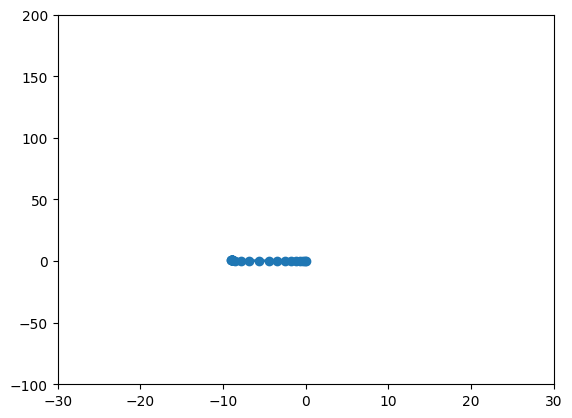

In [1230]:
plot_trajectory(carla_future_poses, index=carla_index)

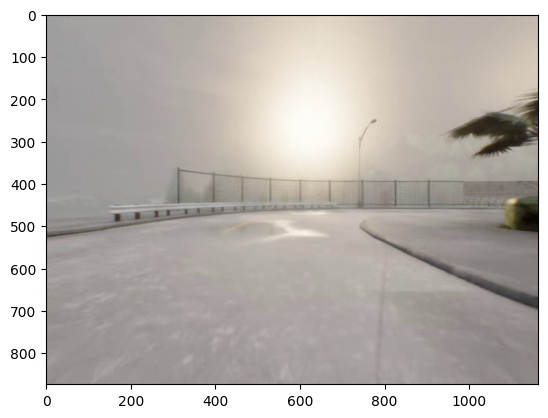

In [1231]:
carla_imgs = load_video_images((carla_path / "video.hevc").as_posix())
carla_frame = Image.fromarray(carla_imgs[carla_index][:, :, ::-1])
plt.imshow(np.array(carla_frame))



Here we can see that the 

# comma2k19

In [1232]:
comma_positions = np.load(comma_path / "global_pose/frame_positions")
# The comma rotations should be global rotations
comma_orientations = np.load(comma_path / "global_pose/frame_orientations")
print("comma_positions.shape", comma_positions.shape)
print("comma_orientations.shape", comma_orientations.shape)


comma_positions.shape (1200, 3)
comma_orientations.shape (1200, 4)


In [1233]:
comma_orientations[0:5]

array([[ 0.23005, -0.81196, -0.40265, -0.35449],
       [ 0.23055, -0.81165, -0.40324, -0.35421],
       [ 0.23093, -0.8114 , -0.40382, -0.35389],
       [ 0.23113, -0.81121, -0.40434, -0.35359],
       [ 0.23108, -0.81113, -0.40474, -0.35336]])

In [1234]:
# Process comma2k19 poses
comma_future_poses = process_pose(comma_positions, comma_orientations, seq_length)
comma_future_poses.size()

local_from_ecef = array([[ 0.42386,  0.49126,  0.76092],
       [ 0.81791, -0.56848, -0.08859],
       [ 0.38905,  0.65992, -0.64276]])
local_from_ecef = array([[ 0.42338,  0.49187,  0.76079],
       [ 0.81876, -0.56721, -0.08893],
       [ 0.38779,  0.66056, -0.64287]])
local_from_ecef = array([[ 0.42297,  0.49256,  0.76058],
       [ 0.81946, -0.56618, -0.08905],
       [ 0.38676,  0.66093, -0.64311]])
local_from_ecef = array([[ 0.42265,  0.49328,  0.76029],
       [ 0.81989, -0.56558, -0.08884],
       [ 0.38619,  0.6609 , -0.64348]])
local_from_ecef = array([[ 0.42236,  0.49397,  0.76   ],
       [ 0.82011, -0.56536, -0.08831],
       [ 0.38605,  0.66058, -0.64389]])
local_from_ecef = array([[ 0.42203,  0.49473,  0.75969],
       [ 0.82019, -0.56537, -0.08746],
       [ 0.38623,  0.66   , -0.64438]])
local_from_ecef = array([[ 0.4217 ,  0.49542,  0.75942],
       [ 0.82021, -0.56547, -0.08656],
       [ 0.38655,  0.65939, -0.64481]])
local_from_ecef = array([[ 0.42141,  0.49594,  0

local_from_ecef = array([[ 0.3681 ,  0.53964,  0.75716],
       [ 0.84766, -0.5294 , -0.03478],
       [ 0.38207,  0.65462, -0.6523 ]])
local_from_ecef = array([[ 0.36794,  0.53918,  0.75757],
       [ 0.84749, -0.52967, -0.03463],
       [ 0.38259,  0.65478, -0.65183]])
local_from_ecef = array([[ 0.36762,  0.53848,  0.75822],
       [ 0.84736, -0.5299 , -0.0345 ],
       [ 0.3832 ,  0.65517, -0.65108]])
local_from_ecef = array([[ 0.36733,  0.53765,  0.75895],
       [ 0.84725, -0.53007, -0.03456],
       [ 0.38371,  0.65571, -0.65024]])
local_from_ecef = array([[ 0.36721,  0.53695,  0.7595 ],
       [ 0.84721, -0.53012, -0.03483],
       [ 0.38393,  0.65624, -0.64957]])
local_from_ecef = array([[ 0.36722,  0.53653,  0.7598 ],
       [ 0.84724, -0.53004, -0.0352 ],
       [ 0.38383,  0.65666, -0.64921]])
local_from_ecef = array([[ 0.36737,  0.53631,  0.75987],
       [ 0.84728, -0.52995, -0.03559],
       [ 0.38361,  0.6569 , -0.6491 ]])
local_from_ecef = array([[ 0.3676 ,  0.53634,  0

torch.Size([999, 33, 3])

In [1235]:

comma_index = 350
comma_future_poses[comma_index][[0, 1, 2, 5, 10, 15, 20]].numpy()

array([[ 0.     ,  0.     ,  0.     ],
       [ 0.16907,  0.00181, -0.00647],
       [ 0.6763 ,  0.00725, -0.02589],
       [ 4.22971,  0.04781, -0.15917],
       [17.01613,  0.17342, -0.62135],
       [38.58319,  0.23843, -1.37332],
       [69.18061,  0.59637, -2.56594]], dtype=float32)

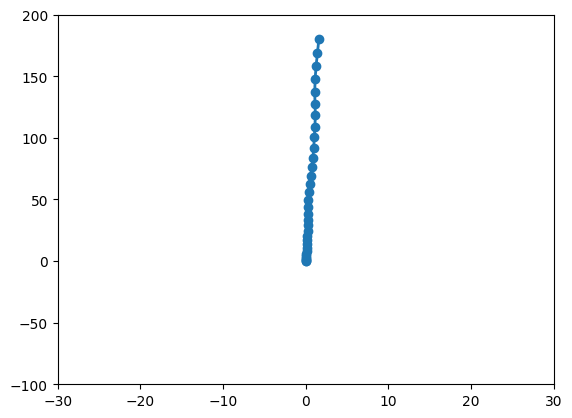

In [1236]:
plot_trajectory(comma_future_poses, index=comma_index)

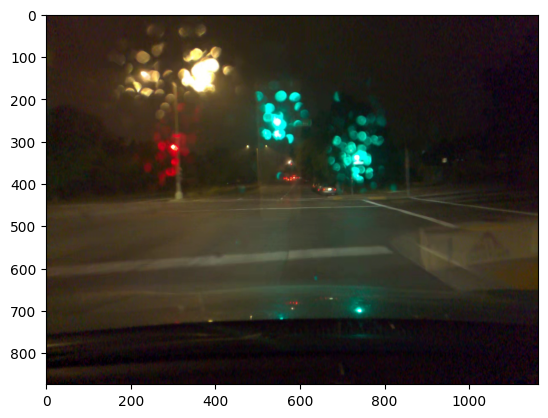

In [1237]:
comma_imgs = load_video_images((comma_path / "video.hevc").as_posix())
comma_frame = Image.fromarray(comma_imgs[comma_index][:, :, ::-1])
plt.imshow(np.array(comma_frame))